# Predicting Potential Strokes

Group Members: Maxwell Arena, Nathan Poteet, Sanjay Srikumar, Akshay Shivkumar

# Why is it important to predict strokes?
Strokes are the 4th health related cause of death in the United States, trailing behind Heart Disease, Cancer, and Lower Respiratory Ilnesses. In 2019 alone, there were 150,005 deaths related to strokes. There is a lot of overlap between heart disease and strokes according to the CDC, and as they are all cardiovasular illnesses, which combined, account for 1/3 of all deaths in the United States. There are a number of ways that strokes affect the daily lives of people in this country, such as loss of major sensory function and reduced brain capacity. We see that dogs are fit to predict cancer in potential cancer patients given a blood sample to almost a 97% accuracy. 

Sources taken from statistics from the Center for Disease Control (cdc.gov)







In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f
from sklearn import model_selection
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import statsmodels.formula.api as smf
import requests
from sklearn import svm, tree
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from matplotlib import pyplot
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import keras


In [163]:
original_df = pd.read_csv('./healthcare-dataset-stroke-data.csv')
original_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [164]:
df = original_df.copy().dropna() # Getting rid of rows with NaN 

# Mapping categorical variables to numbers so the model can make sense of data
dict1 = {'Self-employed': 0, 'Private': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4}
dict2 = {'Male': 0, 'Female': 1, 'Other': 2}
dict3 = {'never smoked': 0, 'formerly smoked': 1, 'Unknown': 2, 'smokes': 3}
dict4 = {'Urban': 0, 'Rural': 1}
dict5 = {'No': 0, 'Yes': 1}
for row in df.iterrows():
  df.at[row[0], 'work_type'] = dict1[row[1]['work_type']]
  df.at[row[0], 'gender'] = dict2[row[1]['gender']]
  df.at[row[0], 'smoking_status'] = dict3[row[1]['smoking_status']]
  df.at[row[0], 'Residence_type'] = dict4[row[1]['Residence_type']]
  df.at[row[0], 'ever_married'] = dict5[row[1]['ever_married']]
  
encoded_data= df.drop(['stroke', 'id'], axis=1) #one hot encoded sort of
encoded_data['avg_glucose_level'] = (np.array(encoded_data['avg_glucose_level']) - np.mean(encoded_data['avg_glucose_level']))/max(encoded_data['avg_glucose_level'])
encoded_data['bmi'] = (np.array(encoded_data['bmi']) - np.mean(encoded_data['bmi']))/max(encoded_data['bmi'])
encoded_data['age'] = (np.array(encoded_data['age']) - np.mean(encoded_data['age']))/max(encoded_data['age'])
encoded_data['stroke'] = df['stroke']
correlations = encoded_data.corrwith(encoded_data["stroke"]) #correlation of variables in original df
print(correlations)


age                  0.232331
hypertension         0.142515
heart_disease        0.137938
avg_glucose_level    0.138936
bmi                  0.042374
stroke               1.000000
dtype: float64


In [196]:
def confusion_mtrx(actual, prediction):
    # if not isinstance(actual, np.ndarray):
    #     print(type(actual))
    #     prediction = tf.make_ndarray(prediction)
    #     actual = tf.make_ndarray(actual)
    # View results as a confusion matrix to visualize our performance metrics
    cm = confusion_matrix(actual, prediction)
    cm = np.array(confusion_matrix(actual, prediction, labels=[1,0]))
    confusion_tree = pd.DataFrame(cm, index=['stroke', 'no_stroke'],
                            columns=['predicted_stroke','predicted_no_stroke'])
    print('Confusion matrix for model: \n', confusion_tree)
    print('Classification report: \n', classification_report(actual, prediction))

In [166]:
print("Features: ", list(encoded_data.keys()))
data = np.asarray(encoded_data.drop(['stroke'], axis = 1))
print(np.shape(data))
X_train, X_test, Y_train, Y_test = train_test_split(data, encoded_data['stroke'], test_size = 0.3, random_state = 78)
X_train, X_test, Y_train, Y_test = X_train.astype(np.float), X_test.astype(np.float), Y_train.astype(np.float), Y_test.astype(np.float)

Features:  ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']
(4909, 10)


In [167]:

#1-20 bias
print("Testing Size before Oversampling:", len(X_train))
oversample = list([i for i,j in zip(X_train,Y_train) if j == 1])
print("Number of positives before Oversampling: ", len(oversample))
X_train = np.array(list(X_train) + (15 * oversample))
Y_train = np.array(list(Y_train) + (15*len(oversample) * [1]))
print("Testing Size with Ovesampling:", len(X_train))
print("Number of positives after Oversampling: ", 15*len(oversample))


Testing Size before Oversampling: 3436
Number of positives before Oversampling:  137
Testing Size with Ovesampling: 5491
Number of positives after Oversampling:  2055


In [168]:
#DECISION TREE
tree_model = tree.DecisionTreeClassifier()
tree_model.fit(X_train, Y_train)
y_predict_tree = tree_model.predict(X_test)
confusion_mtrx(np.array(Y_test), np.array(y_predict_tree))


Confusion matrix for model: 
            predicted_stroke  predicted_no_stroke
stroke                    8                   64
no_stroke                59                 1342
Classification report: 
               precision    recall  f1-score   support

         0.0       0.95      0.96      0.96      1401
         1.0       0.12      0.11      0.12        72

    accuracy                           0.92      1473
   macro avg       0.54      0.53      0.54      1473
weighted avg       0.91      0.92      0.92      1473



0

In [169]:
#RANDOM FORREST
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 3, criterion = 'entropy')
rf.fit(X_train, Y_train)
y_predict_forest = rf.predict(X_test)
y_predict_forest = y_pred = [1 if i > 0.5 else 0 for i in y_predict_forest]
confusion_mtrx(np.array(Y_test), np.array(y_predict_forest))

Confusion matrix for model: 
            predicted_stroke  predicted_no_stroke
stroke                    6                   66
no_stroke                34                 1367
Classification report: 
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      1401
         1.0       0.15      0.08      0.11        72

    accuracy                           0.93      1473
   macro avg       0.55      0.53      0.54      1473
weighted avg       0.91      0.93      0.92      1473



0

In [170]:
#RANDOM FOREST WITH BOOSTING
# Import the model we are using
from xgboost import XGBRFClassifier
rf = XGBRFClassifier(n_estimators=100, use_label_encoder=False, verbose = True)
rf.fit(X_train, Y_train)
y_predict_forest = rf.predict(X_test)
y_predict_forest = [1 if i > 0.5 else 0 for i in y_predict_forest]

confusion_mtrx(np.array(Y_test), np.array(y_predict_forest))

[15:40:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:40:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion matrix for model: 
            predicted_stroke  predicted_no_stroke
stroke                   41                   31
no_stroke               155                 1246
Classification report: 
               precision    recall  f1-score   support

   

0

In [171]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=100) # tuned to 100
knn.fit(X_train, Y_train)
y_predict_knn = knn.predict(X_test)
y_predict_knn = [1 if i > 0.5 else 0 for i in y_predict_knn]
confusion_mtrx(np.array(Y_test), np.array(y_predict_knn))

Confusion matrix for model: 
            predicted_stroke  predicted_no_stroke
stroke                   34                   38
no_stroke               195                 1206
Classification report: 
               precision    recall  f1-score   support

         0.0       0.97      0.86      0.91      1401
         1.0       0.15      0.47      0.23        72

    accuracy                           0.84      1473
   macro avg       0.56      0.67      0.57      1473
weighted avg       0.93      0.84      0.88      1473



0

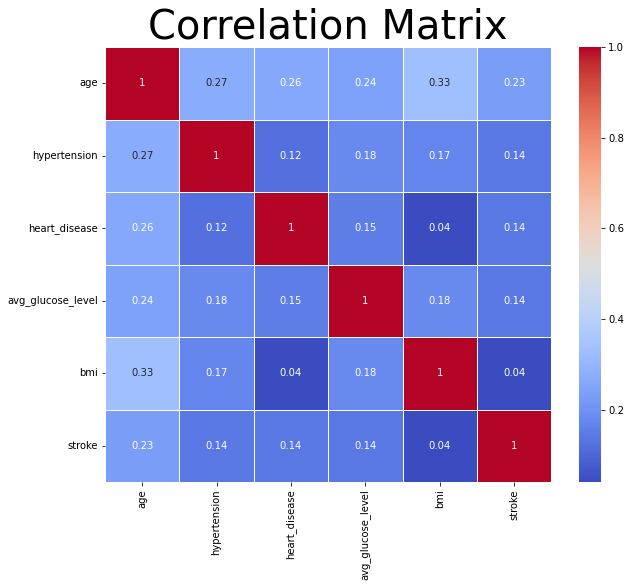

In [197]:
import seaborn as sns

plt.figure(figsize=(10, 8))
correlation_matrix = encoded_data.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix", size=40)
plt.show()


In [191]:
#MODELS
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve,
]

def create_model2(idim = len(encoded_data.keys())-1):
  model = Sequential()

  model.add(Dense(32, input_dim=idim))
  model.add(Dropout(.3))
  model.add(Activation('gelu'))

  model.add(Dense(64, input_dim=32))
  model.add(Dropout(.3))
  model.add(Activation('gelu'))

  model.add(Dense(128, input_dim=64))
  model.add(Dropout(.5))
  model.add(Activation('gelu'))


  model.add(Dense(64, input_dim=128))
  model.add(Dropout(.3))
  model.add(Activation('gelu'))
  
  model.add(Dense(32, input_dim=64))
  model.add(Dropout(.1))
  model.add(Activation('gelu'))

  model.add(Dense(1, input_dim=64))
  model.add(Activation('sigmoid'))

  optimizer = tf.keras.optimizers.SGD(
    learning_rate=1e-3, nesterov=False,
  )
  #tfa.losses.SigmoidFocalCrossEntropy()
  model.compile(optimizer = optimizer, loss= tf.keras.losses.BinaryCrossentropy(),  metrics=METRICS)
  return model


def create_model(idim = len(encoded_data.keys())-1):
  model = Sequential()
  initializer = tf.keras.initializers.HeNormal()
  model.add(Dense(idim, input_dim=idim, kernel_initializer=initializer))
  model.add(Activation('relu'))
  model.add(Dense(32, kernel_initializer=initializer))
  model.add(Activation('relu'))
  model.add(Dense(64,  kernel_initializer=initializer))
  model.add(Activation('relu'))
  model.add(Dense(32, kernel_initializer=initializer))
  model.add(Activation('relu'))
  model.add(Dense(1, kernel_initializer=initializer))
  model.add(Activation('sigmoid'))
  # optimizer = tf.keras.optimizers.SGD(name="SGD")

  model.compile(optimizer = 'sgd', loss=tf.keras.losses.BinaryCrossentropy(),  metrics=METRICS)
  return model

class_weight = compute_class_weight(class_weight = 'balanced', classes = [0,1], y = np.array(df.stroke))
# class_weight = {0: class_weight[0],
#                 1: class_weight[1]}
model = create_model2()
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_159 (Dense)           (None, 32)                352       
                                                                 
 dropout_125 (Dropout)       (None, 32)                0         
                                                                 
 activation_154 (Activation)  (None, 32)               0         
                                                                 
 dense_160 (Dense)           (None, 64)                2112      
                                                                 
 dropout_126 (Dropout)       (None, 64)                0         
                                                                 
 activation_155 (Activation)  (None, 64)               0         
                                                                 
 dense_161 (Dense)           (None, 128)             

In [192]:

history = model.fit(x=X_train.astype(np.float), y=Y_train.astype(np.float), batch_size=8, epochs=50, validation_data=(X_test, Y_test), verbose=1, shuffle=True, callbacks=
                                [ModelCheckpoint(filepath='./ckpts/best_val_loss.hdf5',
                                               monitor= 'val_loss',
                                               save_best_only=True,
                                               mode='auto',
                                               save_weights_only=True,
                                               verbose=2),
                                EarlyStopping(monitor='val_loss',
                                             mode='auto',
                                             patience=100,
                                             verbose=1),  
                                ReduceLROnPlateau(
                                monitor='loss', factor=0.1, patience=10, verbose=1,
                                mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
                            )])

Epoch 1/50
672/687 [============================>.] - ETA: 0s - loss: 0.6840 - tp: 342.0000 - fp: 539.0000 - tn: 2699.0000 - fn: 1796.0000 - accuracy: 0.5657 - precision: 0.3882 - recall: 0.1600 - auc: 0.5316 - prc: 0.4029
Epoch 00001: val_loss improved from inf to 0.62179, saving model to ./ckpts/best_val_loss.hdf5
687/687 [==============================] - 6s 4ms/step - loss: 0.6840 - tp: 344.0000 - fp: 542.0000 - tn: 2757.0000 - fn: 1848.0000 - accuracy: 0.5647 - precision: 0.3883 - recall: 0.1569 - auc: 0.5306 - prc: 0.4038 - val_loss: 0.6218 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1401.0000 - val_fn: 72.0000 - val_accuracy: 0.9511 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5981 - val_prc: 0.0888 - lr: 0.0010
Epoch 2/50
675/687 [============================>.] - ETA: 0s - loss: 0.6747 - tp: 25.0000 - fp: 93.0000 - tn: 3150.0000 - fn: 2132.0000 - accuracy: 0.5880 - precision: 0.2119 - recall: 0.0116 - auc: 0.5400 - prc: 0.4079
Epoch 00002: val_loss

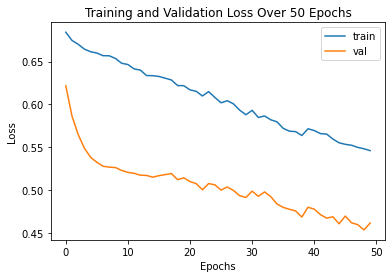

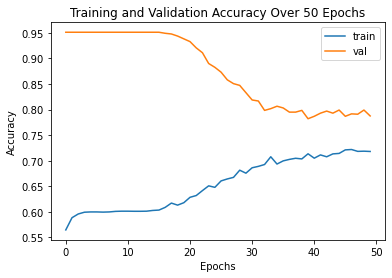

Testing cross entropy: 2
Confusion matrix for model: 
            predicted_stroke  predicted_no_stroke
stroke                   47                  271
no_stroke                25                 1130
Classification report: 
               precision    recall  f1-score   support

           0       0.81      0.98      0.88      1155
           1       0.65      0.15      0.24       318

    accuracy                           0.80      1473
   macro avg       0.73      0.56      0.56      1473
weighted avg       0.77      0.80      0.75      1473



0

In [195]:
history.history['loss']
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.xlabel("Epochs")
pyplot.ylabel("Loss")
pyplot.title("Training and Validation Loss Over %d Epochs" % (len(history.history['loss']),))
pyplot.legend()
pyplot.show()

history.history['accuracy']
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='val')
pyplot.xlabel("Epochs")
pyplot.ylabel("Accuracy")
pyplot.title("Training and Validation Accuracy Over %d Epochs" % (len(history.history['loss']),))
pyplot.legend()
pyplot.show()
 
from sklearn.metrics import log_loss # The data is binary
from math import sqrt

model.built = True
model.load_weights("ckpts/best_val_loss.hdf5")
y_pred = model.predict(X_test)
y_pred = [1 if i > 0.5 else 0 for i in y_pred] # roc curve when you change threshold
cross_entropy = log_loss(Y_test, y_pred)
print("Testing cross entropy: %d" % sqrt(cross_entropy))
confusion_mtrx(y_pred, Y_test)



In [ ]:
oversample = list([i for i,j in zip(X_test,Y_test) if j == 1]) # 50-50 splitish
x = np.array(list(X_test))
y = np.array(list(Y_test))
y_pred  = model.predict(x)
y_pred = [1 if i > 0.5 else 0 for i in y_pred]
accuracy =  np.sum(y == y_pred)
print(f"Testing accuracy: {accuracy/len(y_pred)}")

print(y_pred)

[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 

In [ ]:
print(np.sum(y_pred==y)/len(y))


0.9473742583042201
